In [16]:
import pandas as pd
import random
from collections import Counter 
import operator
import math
import mmh3
import numpy as np
import time
import matplotlib.pylab as plt
plt.style.use('Solarize_Light2')
import sys
from functools import reduce
%matplotlib inline

In [17]:
# Select the dataset
data_file = 'capture20110817.pcap.netflow.labeled' # dataset 50, scenario 9

In [ ]:
infected_host = '147.32.84.165'
columns=['Date','Duration','Protocol','SrcIP', 'srcPort','DstIP', 'DstPort', 'Flags', 'TOS', 'Packets', 'Bytes', 'Label']
lst=[]
with open(data_file) as fp:
    for cnt, line in enumerate(fp):
        if cnt!=0:
            data=line.strip().split("\t")
            data = list(filter(None, data)) 
            date = data[0]
            duration = data[1]
            protocol = data[2]
            src = data[3].split(':')
            if len(src) < 2: # Set port to 0 if no port provided
                src.append(0)
            dst = data[5].split(':')
            if len(dst) < 2:
                dst.append(0)
            if (src[0] != infected_host and dst[0] != infected_host):
                continue  # skip rows that are not about the infected host to save memory
            flags = data[6]
            tos = data[7]
            packets = data[8]
            byteno = data[9]
            flows = data[10]
            label = data[11].rstrip()
            lst.append([date, duration, protocol, src[0], src[1], dst[0], dst[1], flags, tos, packets, byteno, label])
df=pd.DataFrame(lst, columns=columns)
df.head()

del lst
df_infected = df

In [4]:
df_infected.to_pickle(data_file + '_pickled.pkl')

In [19]:
df_infected = pd.read_pickle(data_file + '_pickled.pkl')

In [20]:
# Count connections
ip_map = {}
ip_list = []
for index, row in df_infected.iterrows():
    if row["SrcIP"] == infected_host:
        ip_map.setdefault(row["DstIP"],0)
        ip_map[row["DstIP"]] += 1
        ip_list.append(row["DstIP"])
    else:
        ip_map.setdefault(row["SrcIP"],0)
        ip_map[row["SrcIP"]] += 1
        ip_list.append(row["SrcIP"])
        

In [21]:
# Show the 10 most frequestly connecting IPs 
print(Counter(ip_map).most_common(10))
assert len(df_infected) == sum(Counter(ip_map).values())
len(df_infected)

[('147.32.80.9', 30533), ('212.117.171.138', 1851), ('188.72.241.107', 1203), ('173.192.170.88', 857), ('204.12.208.59', 493), ('195.190.13.78', 477), ('74.125.39.27', 314), ('209.190.94.170', 310), ('83.133.119.197', 212), ('65.54.188.72', 183)]


48186

In [22]:
# Calculate the exact fequencies
most_freq_ips = Counter(ip_map).most_common(10)
for ip in Counter(ip_map).most_common(10):
    print(f"{ip[0]} : {(ip[1] / len(df_infected) * 100)}%")


147.32.80.9 : 63.364877765326035%
212.117.171.138 : 3.841364711742%
188.72.241.107 : 2.49657576889553%
173.192.170.88 : 1.7785248827460256%
204.12.208.59 : 1.0231187481841197%
195.190.13.78 : 0.9899140829286515%
74.125.39.27 : 0.6516415556385672%
209.190.94.170 : 0.6433403893247002%
83.133.119.197 : 0.4399618146349562%
65.54.188.72 : 0.37977835885941974%


In [23]:
def selectKItems(stream, n, k): 
    i=0
    reservoir = [0]*k
    for i in range(k): 
        if (df_infected.iloc[i, :]["DstIP"] == infected_host):
            reservoir[i] = df_infected.iloc[i, :]["SrcIP"]
        else:
            reservoir[i] = df_infected.iloc[i, :]["DstIP"]

    while(i < n): 
        j = random.randrange(i+1)
        
        if(j < k): 
            if (df_infected.iloc[i, :]["DstIP"] == infected_host):
                reservoir[j] = df_infected.iloc[i, :]["SrcIP"]
            else:
                reservoir[j] = df_infected.iloc[i, :]["DstIP"]
        i+=1
    
    return reservoir

In [24]:
reservoirSizes = [100, 250, 500, 1000, 5000, 10000, 25000, len(df_infected)]
mem_reservoir = {}
for reservoir in reservoirSizes:
    print(f"\n\nReservoir size = {reservoir}")
    kfreqIPS = selectKItems(df_infected, len(df_infected), reservoir)
    memsize = reduce((lambda acc, y: acc + sys.getsizeof(y)), kfreqIPS, 0)
    for ip in Counter(kfreqIPS).most_common(10):
        print(f"{ip[0]} & {ip[1]} & {(ip[1] / len(kfreqIPS) * 100)}\\% \\\\ \\hline")
    
    mem_reservoir[reservoir] = memsize
    print(f"Memory used for reservoir: {memsize} bytes")
    
    
print("measuring runtimes")
reservoirs = range(100,40000, 500)
time_reservoir = []
for reservoir in reservoirs:
    print(f"Reservoir size = {reservoir}")
    starttime = time.time()
    kfreqIPS = selectKItems(df_infected, len(df_infected), reservoir)
    time_reservoir.append(time.time() - starttime)
    print(f"time taken: {time_reservoir[-1]}")
    



Reservoir size = 100
147.32.80.9 & 72 & 72.0\% \\ \hline
212.117.171.138 & 7 & 7.000000000000001\% \\ \hline
173.192.170.88 & 3 & 3.0\% \\ \hline
74.125.39.27 & 2 & 2.0\% \\ \hline
209.190.94.170 & 1 & 1.0\% \\ \hline
205.188.190.2 & 1 & 1.0\% \\ \hline
62.78.41.160 & 1 & 1.0\% \\ \hline
168.61.70.72 & 1 & 1.0\% \\ \hline
206.46.232.39 & 1 & 1.0\% \\ \hline
65.54.188.94 & 1 & 1.0\% \\ \hline
Memory used for reservoir: 6069 bytes


Reservoir size = 250
147.32.80.9 & 162 & 64.8\% \\ \hline
212.117.171.138 & 13 & 5.2\% \\ \hline
65.54.188.72 & 5 & 2.0\% \\ \hline
188.72.241.107 & 4 & 1.6\% \\ \hline
173.192.170.88 & 3 & 1.2\% \\ \hline
195.190.13.78 & 2 & 0.8\% \\ \hline
204.12.208.59 & 2 & 0.8\% \\ \hline
74.125.39.27 & 2 & 0.8\% \\ \hline
74.117.116.126 & 2 & 0.8\% \\ \hline
98.139.54.60 & 2 & 0.8\% \\ \hline
Memory used for reservoir: 15197 bytes


Reservoir size = 500
147.32.80.9 & 328 & 65.60000000000001\% \\ \hline
212.117.171.138 & 16 & 3.2\% \\ \hline
188.72.241.107 & 12 & 2.4\%

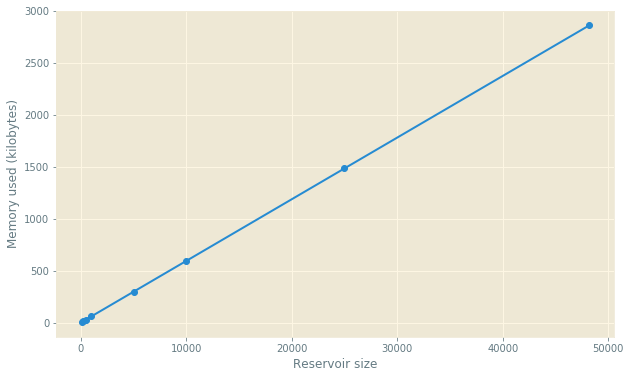

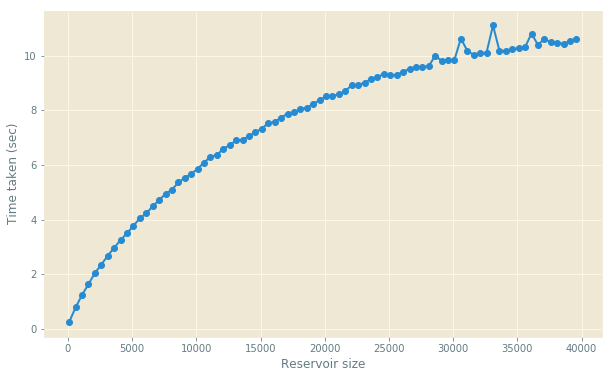

In [25]:
lists = sorted(mem_reservoir.items()) # sorted by key, return a list of tuples
# Memory plot
x, y = zip(*lists) # unpack a list of pairs into two tuples
y = [n/1024 for n in y]
plt.figure(figsize=(10,6))
plt.plot(x, y, marker='o')
plt.xlabel("Reservoir size")
plt.ylabel("Memory used (kilobytes)")
plt.savefig('memory_reservoir.png')
plt.show()

# Runtimes plot
plt.figure(figsize=(10,6))
plt.plot(range(100,40000, 500), time_reservoir, marker='o')
plt.xlabel("Reservoir size")
plt.ylabel("Time taken (sec)")
plt.savefig('time_reservoir.png')
plt.show()


# COUNT-MIN sketch


In [26]:
class CountMinSketch:
    def __init__(self, width, length):
        self.size = width*length
        self.width = width
        self.hash_count = length
        self.sketch =  np.zeros(shape=(length, width))
        
    def add(self, string):
        for seed in range(self.hash_count):
            result = mmh3.hash(string, seed) % self.width
            self.sketch[seed][result] += 1
        
    def find_freq(self, string):
        values = []
        for seed in range(self.hash_count):
            result = mmh3.hash(string, seed) % self.width
            values.append(self.sketch[seed][result])
        return min(values)

In [27]:
ips = list(ip_map.keys())
top_ten_total = sum(sorted(Counter(ip_map).values(), reverse=True)[:10])
run_times = {}

print("Sketch width: 4 , 8 , 16, 32 , 64 , 128 , 256 , 512 , 1024 , 2048 , 4096")
for l in list(reversed([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])):
    print(f"hash num: {l} & ", end="")
    tmp_runtimes = []
    for w in [4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]:
        start_time = time.time()
        count_min_matrix = CountMinSketch(int(w), int(l))

        for ip in ip_list:
                count_min_matrix.add(ip)
                
        # find frequencies
        count_min = {}
        for ip in ips:
            count_min[ip] = count_min_matrix.find_freq(ip)
        
        tmp_runtimes.append(time.time() - start_time)
        # sort with most frequent on top
        sorted_count_min = sorted(count_min.items(), key=lambda kv: kv[1], reverse = True)
        difference_w_ground = 0
        for i in range(10):
            #find the difference between the count min and the ground truth for top 10
            difference_w_ground+= abs(sorted_count_min[i][1] - most_freq_ips[i][1])
        accuracy = 100-(difference_w_ground*100.0/top_ten_total)
        
        ## Print Readable format
#         print(f'For mod={w} and {l} hash-functions, accuracy={ accuracy } %')
        
        ## Print LaTeX table
#         if w == 4096:
#             print("{:0.2f}\\% \\\\ \\hline".format(accuracy))
#         else:
#             print("{:0.2f}\\% & ".format(accuracy), end="")

        ## Print CSV
        print("{:0.2f}%, ".format(accuracy), end="") ## printing accuracy
#         print(f"{count_min_matrix.sketch.nbytes}, ", end="") ## print memusage
        if w == 4096:
            print("")
            run_times[l] = np.mean(tmp_runtimes)

Sketch width: 4 , 8 , 16, 32 , 64 , 128 , 256 , 512 , 1024 , 2048 , 4096
hash num: 12 & 4.40%, 59.79%, 82.70%, 93.50%, 97.52%, 99.08%, 99.71%, 99.91%, 99.99%, 100.00%, 100.00%, 
hash num: 11 & -0.33%, 57.79%, 82.43%, 93.31%, 97.32%, 98.93%, 99.68%, 99.88%, 99.99%, 100.00%, 100.00%, 
hash num: 10 & -2.34%, 57.35%, 81.96%, 93.14%, 97.15%, 98.82%, 99.67%, 99.88%, 99.99%, 100.00%, 100.00%, 
hash num: 9 & -15.93%, 55.11%, 81.90%, 92.87%, 97.02%, 98.82%, 99.67%, 99.88%, 99.99%, 100.00%, 100.00%, 
hash num: 8 & -21.05%, 48.20%, 81.44%, 92.41%, 97.02%, 98.81%, 99.59%, 99.88%, 99.99%, 100.00%, 100.00%, 
hash num: 7 & -30.93%, 36.88%, 80.44%, 91.90%, 96.85%, 98.81%, 99.59%, 99.87%, 99.97%, 99.99%, 100.00%, 
hash num: 6 & -31.21%, 34.53%, 77.20%, 91.35%, 96.78%, 98.81%, 99.58%, 99.87%, 99.97%, 99.99%, 100.00%, 
hash num: 5 & -114.09%, 25.54%, 73.05%, 88.61%, 96.22%, 98.70%, 99.47%, 99.85%, 99.96%, 99.99%, 100.00%, 
hash num: 4 & -778.15%, -215.17%, 67.39%, 85.30%, 95.42%, 98.70%, 99.44%, 99.85%, 

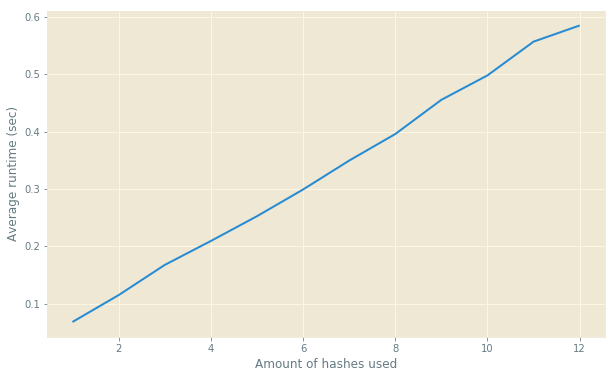

In [28]:
lists = sorted(run_times.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.figure(figsize=(10,6))
plt.plot(x, y)
plt.xlabel("Amount of hashes used")
plt.ylabel("Average runtime (sec)")
plt.savefig('runtimes_countmin.png')
plt.show()
